In [ ]:
#!. Достаем наши скореллированные lncRNA
#2. Делаем поправку на множественное тестирование(потом надо будет перенести отсюда)
#3. Получаем набор название генов lncRNA из ensembl
#4. Теперь нам нужен файл последовательностей транскриптов этих генов(по ensg из gff можно получить координаты всех его транскриптов)
#5. Запускаем триплексатор - строим табличку соответствия транскрипт-бин-скор

In [ ]:
import nbimporter
import load_data as ld
from save_ipython_variables import load_all_variables, save_variable
import operator
from BCBio import GFF
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
#import pybedtools
import os
import subprocess
import pandas as pd
from Bio import SeqIO
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from scipy.special import binom, betainc
from scipy.stats import logser
from scipy.optimize import newton
import gffutils
import shutil
import math

In [3]:
binStep = 150

In [383]:
load_all_variables(['corrs10', 'WGbinsWithBigStd', 'WGBinsCoords'])

Loaded the following variables: ['corrs10', 'WGbinsWithBigStd', 'WGBinsCoords']


In [39]:
len(filteredLncRNAData10)

150

In [40]:
#Сколько на самом деле посчитали корреляций
185501*150

27825150

In [384]:
flattenCorrs = [(k, pvalue) for c in corrs10 for k, v in c.iteritems() for pvalue in v]

In [42]:
len(flattenCorrs)

954647

In [385]:
correct_pv = correct_pvalues_for_multiple_testing([i[1][3] for i in flattenCorrs], 27825150)

In [44]:
len(correct_pv)

954647

In [386]:
flattenCorrsWithCorrectPv = [(c[0], (c[1][0], c[1][1], c[1][2], p)) for c, p in zip(flattenCorrs, correct_pv)]

In [46]:
len(flattenCorrsWithCorrectPv)

954647

In [387]:
flattenCorrsWithCorrectPv = [i for i in flattenCorrsWithCorrectPv if i[1][3] < 0.05]

In [388]:
#Скинули только ~300 корреляций и 3 lncRNA, раньше неправильно считал
len(flattenCorrsWithCorrectPv)

954333

In [389]:
g = ""
pairs = {}
for i in flattenCorrsWithCorrectPv:
    if(g != i[0]): g = i[0]
    l = pairs.get(g)
    if(l == None): pairs[g] = []
    pairs[g].append(i[1])

In [392]:
mergedBins = {k: mergeBins(v) for k, v in pairs.iteritems()}
lncWithMergedBinsCount = {k: len(v) for k, v in mergedBins.iteritems() if len(v) != 0}
sortedlncWithMergedBinsCount = sorted(lncWithMergedBinsCount.items(), key=operator.itemgetter(1), reverse=True)
filteredLncRnaGeneSet10 = [g[0] for g in sortedlncWithMergedBinsCount]

In [393]:
len(filteredLncRnaGeneSet10)

147

In [ ]:
#Задача - получить для каждой lncRNA(гена) .gff файл, содержащий все транскрипты(процессированные)(и экзоны) этого гена
#Потом с помощью gffread получим для каждого такого gff файла fa файл с последовательностями процессированных транскриптов
#gffread gencode.v25.annotation.gff3 -g hg38.fa -w hg38.ALL.fna

#Делается один раз
db = gffutils.create_db("gencode.v25lift37.long_noncoding_RNAs.gff3", dbfn='long_noncoding_RNAs.db')

In [366]:
db = gffutils.FeatureDB('long_noncoding_RNAs.db', keep_order=True)

In [412]:
#все транскрипты в одном файле
for g in filteredLncRnaGeneSet10:
    gene = db[g]

    with open("./lnc_gff/all_transcripts_lncRNA.gff3", "a") as myfile:
        for i in db.children(gene, featuretype='transcript', order_by='start'):
            myfile.write(str(i) + "\n")
        for i in db.children(gene, featuretype='exon', order_by='start'):
            myfile.write(str(i) + "\n")
            
cmd = './gffread ./lnc_gff/all_transcripts_lncRNA.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/all_transcripts_lncRNA.fa'     
print cmd
p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
p.wait()

./gffread ./lnc_gff/all_transcripts_lncRNA.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/all_transcripts_lncRNA.fa


0

In [394]:
#свой файл для каждой lncRNA
for g in filteredLncRnaGeneSet10:
    gene = db[g]

    with open("./lnc_gff/" + g + ".gff3", "a") as myfile:
        for i in db.children(gene, featuretype='transcript', order_by='start'):
            myfile.write(str(i) + "\n")
        for i in db.children(gene, featuretype='exon', order_by='start'):
            myfile.write(str(i) + "\n")
            
    cmd = './gffread ./lnc_gff/' + g + '.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/' + g + '_transcript_lncRNA.fa'     
    print cmd
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    p.wait()

./gffread ./lnc_gff/ENSG00000250155.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000250155.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000232698.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000232698.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000262831.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000262831.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000269243.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000269243.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000263986.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000263986.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000254452.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000254452.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000264558.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000264558.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000255114.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG00000255114.1_transcript_lncRNA.fa
./gffread ./lnc_gff/ENSG00000258757.1.gff3 -g ./hg19/allChr.fa -w ./lnc_gff/ENSG

In [ ]:
#Создадим для каждой нкРНК файл, в котором содержатся все ее транскрипты
for lnc_record in SeqIO.parse("./bins_coords/lncRNA.fa", "fasta"):
    lnc_record_name = lnc_record.id.split('::')[0] + ".fa"
    SeqIO.write(lnc_record, "./bins_coords/" + lnc_record_name, "fasta")

In [397]:
#На самом деле все еще проще с координатами(и он учитывает blacklist) - по номеру и хромосоме их можно достать из WGBinsCoords
coords = {k: getCoordsByNumber(v) for k, v in mergedBins.iteritems() if len(v) != 0}

In [158]:
len(coords)

147

In [157]:
#теперь надо создать bed(типа chr1 5 10) файлы с координатами, а потом с помощью bedtools getfasta получить фаста файл
for k, v in coords.iteritems():
    with open("bins_coords/seqs_for_lnc_" + k + '.bed', 'w') as fp:
        fp.write('\n'.join('%s\t%s\t%s' % (x[0], x[1], x[2]) for x in v))

In [159]:
for f in [f for f in os.listdir('./bins_coords/') if f.endswith('.bed')]:
    bed = pybedtools.BedTool("bins_coords/" + f)
    bed = bed.sequence(fi="hg19/allChr.fa", fo="bins_coords/" + os.path.splitext(f)[0] + '.fa', name=True)

In [411]:
os.chdir("/Users/e.mazurov/workspace/Epigenetics")

In [406]:
#У каждой lncRNA есть набор бинов, с которыми надо проверить ее "сродство"(образование триплексов)
os.chdir("./bins_coords/")
dataframes = []
i = 0
for l in coords.keys():
    print 'start ' + str(i) + " lncRNA = " + l
    cmd = './triplexator -l 15 -e 20 -c 2 -fr off -g 20 -m R -fm 0 -of 1 -o ' + l + '.tsv -po -rm 2 -p 3 -ss ../H3K27me3/lnc_gff/' + l + '_transcript_lncRNA.fa -ds ../H3K27me3/peak_coords/seqs_for_lnc_' + l + '.fa'     
    print cmd
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    p.wait()
    result = parseTriplexatorResult(l)
    if(len(result.index) != 0): dataframes.append(result)
    print l + ' ' + str(p.returncode)
    i = i + 1

data = pd.concat(dataframes)
data = data.reset_index(drop=True)

start 0 lncRNA = ENSG00000259974.2
./triplexator -l 15 -e 20 -c 2 -fr off -g 20 -m R -fm 0 -of 1 -o ENSG00000259974.2.tsv -po -rm 2 -p 3 -ss ../lnc_gff/ENSG00000259974.2_transcript_lncRNA.fa -ds seqs_for_lnc_ENSG00000259974.2.fa
ENSG00000259974.2 0
start 1 lncRNA = ENSG00000188242.4
./triplexator -l 15 -e 20 -c 2 -fr off -g 20 -m R -fm 0 -of 1 -o ENSG00000188242.4.tsv -po -rm 2 -p 3 -ss ../lnc_gff/ENSG00000188242.4_transcript_lncRNA.fa -ds seqs_for_lnc_ENSG00000188242.4.fa
ENSG00000188242.4 0
start 2 lncRNA = ENSG00000204876.4
./triplexator -l 15 -e 20 -c 2 -fr off -g 20 -m R -fm 0 -of 1 -o ENSG00000204876.4.tsv -po -rm 2 -p 3 -ss ../lnc_gff/ENSG00000204876.4_transcript_lncRNA.fa -ds seqs_for_lnc_ENSG00000204876.4.fa
ENSG00000204876.4 0
start 3 lncRNA = ENSG00000249679.1
./triplexator -l 15 -e 20 -c 2 -fr off -g 20 -m R -fm 0 -of 1 -o ENSG00000249679.1.tsv -po -rm 2 -p 3 -ss ../lnc_gff/ENSG00000249679.1_transcript_lncRNA.fa -ds seqs_for_lnc_ENSG00000249679.1.fa
ENSG00000249679.1 0
star

In [407]:
data.shape

(60730, 5)

In [408]:
data.to_csv('all_scores.csv')

In [22]:
#длины и GC состав lncRNA
os.chdir('/Users/e.mazurov/workspace/Epigenetics')
lnc = []
for seq_record in SeqIO.parse('./lnc_gff/all_transcripts_lncRNA.fa', "fasta"):
    lnc.append((seq_record.id, len(seq_record), GC(seq_record.seq)))
lnc.sort(key=lambda tup: tup[1], reverse=True)

(array([ 227.,  104.,   23.,   19.,   14.,    4.,    3.,    3.,    1.,    2.]),
 array([  124. ,   689.9,  1255.8,  1821.7,  2387.6,  2953.5,  3519.4,
         4085.3,  4651.2,  5217.1,  5783. ]),
 <a list of 10 Patch objects>)

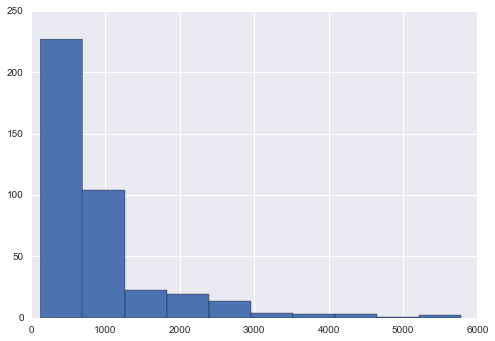

In [26]:
plt.hist([i[1] for i in lnc])

In [416]:
import fnmatch
os.chdir('/Users/e.mazurov/workspace/Epigenetics')
l = []
for f in [f for f in os.listdir('./bins_coords/') if fnmatch.fnmatch(f, 'seqs_for_lnc_*.fa')]:
    for seq_record in SeqIO.parse('./bins_coords/' + f, "fasta"):
        l.append((seq_record.id, len(seq_record), GC(seq_record.seq)))
l.sort(key=lambda tup: tup[1], reverse=True)

In [419]:
trainingSet = {'lncLengths' : [], 'lncGCs' : [], 'binsLengths' : [], 'binsGCs' : []}

lncLengths = [i[1] for i in lnc]
lncGCs = [i[2] for i in lnc]

binsLengths = [j[1] for j in l]
binsGCs = [j[2] for j in l]

for i in [25, 50, 75, 95, 99]:
    trainingSet['lncLengths'].append(int(round(np.percentile(lncLengths, i))))
    trainingSet['lncGCs'].append(int(round(np.percentile(lncGCs, i))))
    trainingSet['binsLengths'].append(int(round(np.percentile(binsLengths, i))))
    trainingSet['binsGCs'].append(int(round(np.percentile(binsGCs, i))))

In [420]:
trainingSet

{'binsGCs': [41, 46, 52, 62, 73],
 'binsLengths': [450, 750, 900, 2100, 3600],
 'lncGCs': [44, 49, 54, 65, 69],
 'lncLengths': [483, 638, 893, 2504, 4277]}

In [445]:
import itertools

permutations = []
for i in itertools.product('01234', repeat=4):
    permutations.append((trainingSet['lncLengths'][int(i[0])], trainingSet['lncGCs'][int(i[1])], trainingSet['binsLengths'][int(i[2])], trainingSet['binsGCs'][int(i[3])]))

In [458]:
[i for i, p in enumerate(permutations) if p == (4277, 49, 900, 52)]

[537]

In [459]:
len(permutations[537:])

88

In [460]:
#s = []
for i in permutations[537:]:
    os.chdir('/Users/e.mazurov/workspace/Epigenetics')
    shutil.rmtree("./score_to_p-value")
    os.mkdir("./score_to_p-value")
    shutil.copyfile("triplexator", "./score_to_p-value/triplexator")
    os.chmod("./score_to_p-value/triplexator", 0o777)
    (scores_without_grouping, scores, counts) = generateScoreDistribution(i[0], i[2], i[1], i[3], 150, 15)
    s.append((scores, counts, scores_without_grouping))
    print 'finish ' + str(i)

./triplexator -l 15 -E 3 -e 20 -c 2 -fr off -g 20 -fm 0 -of 1 -o result_4277_900_49_52_15.tpx -po -rm 2 -p 8 -ss generated_lncRNAs_4277_900_49_52_15.fa -ds generated_bins_4277_900_49_52_15.fa
0
1370 triplexes, Existing sums of triplexes = set([1, 2, 3, 4, 5])
finish (4277, 49, 900, 52)
./triplexator -l 15 -E 3 -e 20 -c 2 -fr off -g 20 -fm 0 -of 1 -o result_4277_900_49_62_15.tpx -po -rm 2 -p 8 -ss generated_lncRNAs_4277_900_49_62_15.fa -ds generated_bins_4277_900_49_62_15.fa
0
1391 triplexes, Existing sums of triplexes = set([1, 2, 3, 4, 5])
finish (4277, 49, 900, 62)
./triplexator -l 15 -E 3 -e 20 -c 2 -fr off -g 20 -fm 0 -of 1 -o result_4277_900_49_73_15.tpx -po -rm 2 -p 8 -ss generated_lncRNAs_4277_900_49_73_15.fa -ds generated_bins_4277_900_49_73_15.fa
0
1488 triplexes, Existing sums of triplexes = set([1, 2, 3, 4, 5, 6])
finish (4277, 49, 900, 73)
./triplexator -l 15 -E 3 -e 20 -c 2 -fr off -g 20 -fm 0 -of 1 -o result_4277_2100_49_41_15.tpx -po -rm 2 -p 8 -ss generated_lncRNAs_4277

In [461]:
save_variable('distributions', s)

In [519]:
#101 - вырожденный случай, только по одному триплексу на пару
regressionData = []
j = 0;
for i in s:
    params = permutations[j]
    try:
        regressionData.append(params + (nbMLE(sum(i[2]), len(i[2])), logserMLE(sum(i[1]), len(i[1]), 0.09)))
    except (ValueError, RuntimeError) as e:
        print "error MLE in " + str(j)
    j = j + 1

error MLE in 101


In [551]:
len(regressionData)

624

In [552]:
d = {'RNALength' : pd.Series([i[0] for i in regressionData], index=range(0, 624)),
   'RNA_GC' : pd.Series([i[1] for i in regressionData], index=range(0, 624)),
     'BinsLength' : pd.Series([i[2] for i in regressionData], index=range(0, 624)),
     'Bins_GC' : pd.Series([i[3] for i in regressionData], index=range(0, 624)),
     'PLogser' : pd.Series([i[5] for i in regressionData], index=range(0, 624))
    }

In [553]:
df = pd.DataFrame(d)
df.to_csv('regressionData.csv')

In [31]:
rdata = pd.read_csv('regressionData.csv', sep=';')

In [26]:
rdata['GCDiff'] = [abs(i) for i in ((rdata['RNA_GC'] - rdata['BinGC']).tolist())]

In [3]:
rdata.head()

,RNALength,RNA_GC,BinLength,BinGC,PNB,PLogser
0,1324,42,450,41,0.196552,0.140304
1,1324,42,450,46,0.197531,0.127061
2,1324,42,450,51,0.196850,0.115294
3,1324,42,450,61,0.197817,0.106360
4,1324,42,600,41,0.197713,0.203733


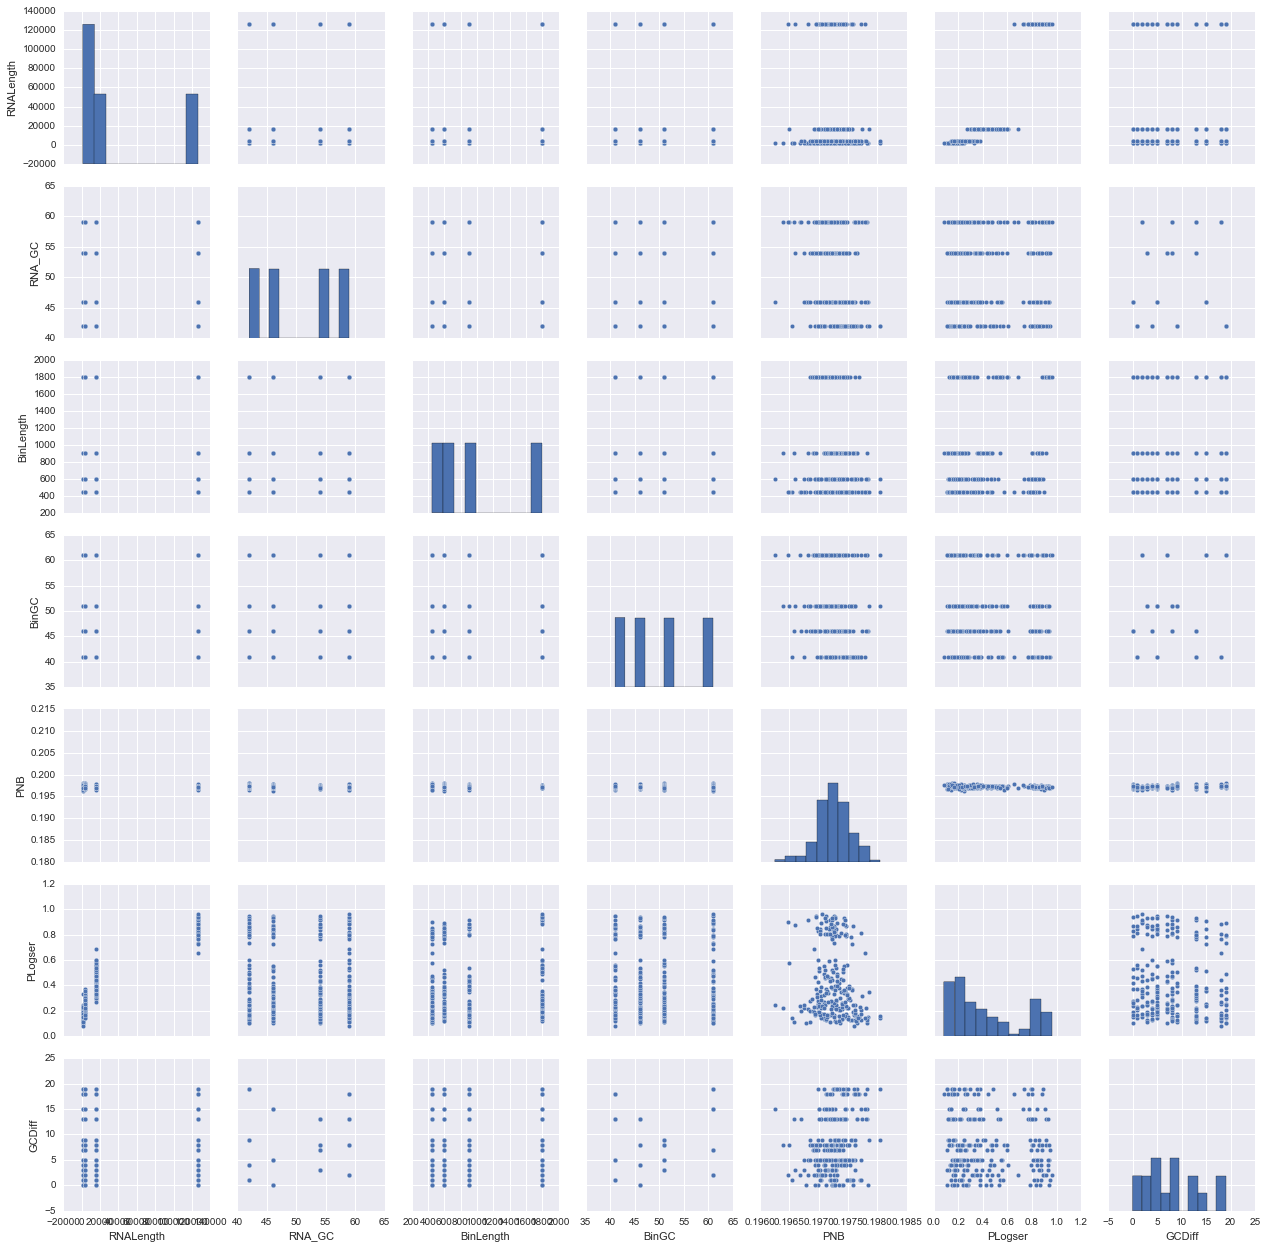

In [28]:
sb.pairplot(rdata)

(array([ 15.,  35.,  23.,  31.,  20.,  11.,  18.,   7.,  12.,   6.,   9.,
          4.,   0.,   2.,   2.,   5.,  19.,  15.,  11.,  11.]),
 array([ 0.08079854,  0.12480321,  0.16880787,  0.21281254,  0.25681721,
         0.30082188,  0.34482654,  0.38883121,  0.43283588,  0.47684055,
         0.52084521,  0.56484988,  0.60885455,  0.65285922,  0.69686388,
         0.74086855,  0.78487322,  0.82887789,  0.87288256,  0.91688722,
         0.96089189]),
 <a list of 20 Patch objects>)

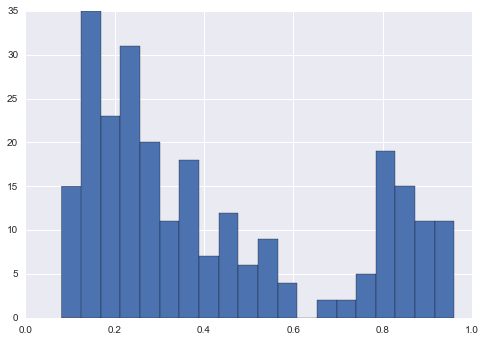

In [22]:
plt.hist(rdata['PLogser'], bins=20)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#Хотим обучить регрессию для предсказания параметра PLogser
#0)Раздеяем на X и y, используем пайплайн, линейную регрессию, кросс валидацию
#1)Используем StandartScaler
#2)Нужно чтобы предсказания регрессии были в диапазоне [0, 1]
X = rdata[['BinLength', 'BinGC', 'RNALength', 'RNA_GC']]
y = rdata['PLogser']

p = Pipeline([('scale', StandardScaler()), ('regression', LinearRegression())])
kfold = KFold(n_splits=4, shuffle=True, random_state=12345)
scores = cross_val_score(p, X, y, cv=kfold)
np.mean(scores)

0.89170613386436637

In [33]:
model = p.fit(X, y)

(array([ 57.,  40.,  41.,  38.,   8.,   8.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  16.,  29.,   3.,  16.]),
 array([ 0.19574232,  0.23306411,  0.27038591,  0.3077077 ,  0.34502949,
         0.38235129,  0.41967308,  0.45699488,  0.49431667,  0.53163846,
         0.56896026,  0.60628205,  0.64360385,  0.68092564,  0.71824743,
         0.75556923,  0.79289102,  0.83021282,  0.86753461,  0.90485641,
         0.9421782 ]),
 <a list of 20 Patch objects>)

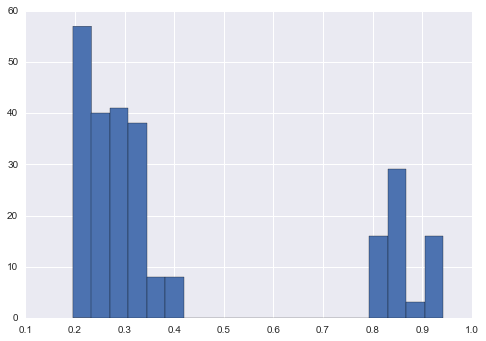

In [34]:
plt.hist(model.predict(X), bins=20)

In [35]:
model.predict(np.array([450, 1, 1324, 42]).reshape(1, -1))

array([ 0.1552827])

In [25]:
allScores = pd.read_csv('all_scores.csv')
addParamsToScoresTable(allScores)
allScores.to_csv('allScores_with_params.csv')

In [27]:
allScores = pd.read_csv('allScores_with_params.csv')

In [36]:
plogser = model.predict(allScores[['BinsLength', 'BinsGC', 'TranscriptLength', 'TranscriptGC']])

(array([  8.98420000e+04,   5.51610000e+04,   1.45040000e+04,
          5.47600000e+03,   2.34000000e+03,   1.22700000e+03,
          4.56000000e+02,   3.43000000e+02,   1.22000000e+02,
          1.09000000e+02,   5.00000000e+01,   2.90000000e+01,
          1.00000000e+01,   4.60000000e+01,   7.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.20000000e+01]),
 array([ 0.17319521,  0.22736494,  0.28153468,  0.33570441,  0.38987415,
         0.44404388,  0.49821362,  0.55238335,  0.60655309,  0.66072283,
         0.71489256,  0.7690623 ,  0.82323203,  0.87740177,  0.9315715 ,
         0.98574124,  1.03991097,  1.09408071,  1.14825044,  1.20242018,
         1.25658992]),
 <a list of 20 Patch objects>)

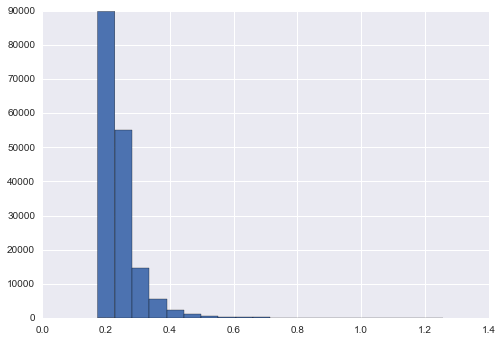

In [39]:
plt.hist(plogser, bins=20)

In [28]:
allScores['Score'].shape

(169737,)

In [80]:
def partitionIndex(listLength):
    i = 200
    indices = []
    while i < listLength:
        indices.append(i)
        i = i + 200
    return [(i, j if j is not None else listLength) for i, j in zip([0]+indices, indices+[None])]

In [34]:
def partitionList(l):
    i = 200
    indices = []
    listLength = len(l)
    while i < listLength:
        indices.append(i)
        i = i + 200
    return [l[i:(j if j is not None else listLength)] for i, j in zip([0]+indices, indices+[None])]

In [81]:
len(partition(allScores.shape[0]))

849

In [41]:
pnb = 0.197

In [83]:
from multiprocessing import Pool
pool = Pool(8)

p_value = []
p_value = pool.map(calcPvalues, partitionIndex(allScores.shape[0]))

pool.close()
pool.join()

16400
200
5600
21800
27200
38000
16600
32600
400
16800
22000
5800
27400
38200
22200
17000
32800
17200
27600
33000
600
6000
22400
38400
17400
33200
800
38600
1000
17600
33400
1200
22600
27800
6200
38800
17800
33600
18000
11000
22800
39000
18200
33800
28000
18400
39200
34000
18600
23000
39400
18800
34200
19000
39600
19200
34400
28200
19400
23200
19600
34600
39800
19800
34800
28400
6400
1400
20000
20200
35000
20400
40000
28600
20600
35200
11200
20800
35400
23400
35600
6600
28800
35800
21000
23600
36000
36200
23800
29000
6800
21200
40200
36400
24000
29200
36600
21400
7000
29400
24200
21600
1600
36800
29600
11400
37000
24400
24600
29800
37200
24800
37400
30000
25000
1800
30200
37600
25200
7200
30400
43400
40400
37800
30600
25400
2000
25600
30800
48800
11600
25800
26000
40600
49000
2200
43600
7400
31000
26200
49200
26400
31200
11800
26600
26800
43800
49400
2400
27000
2600
7600
40800
2800
31400
12000
49600
3000
3200
3400
3600
3800
54200
44000
4000
4200
4400
49800
4600
4800
5000
7800
5200
5400

In [88]:
pv = [item for sublist in p_value for item in sublist]
pv.sort(key=lambda tup: tup[0])

In [89]:
len([i for i in pv if i[1] < 0.05])

112452

In [90]:
allScores['p-value'] = [i[1] for i in pv]

In [95]:
allScores.to_csv('allScores_with_p_value.csv')

In [92]:
correct = correct_pvalues_for_multiple_testing([p[1] for p in pv], len(pv))

In [93]:
len([i for i in correct if i < 0.05])

112452

In [14]:
allScores = pd.read_csv('allScores_with_p_value.csv')
filtered = allScores[allScores['p-value'] < 0.05]

In [103]:
Transcript

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,lncRNA,Transcript,Bin,Score,Corr,TranscriptLength,TranscriptGC,BinsLength,BinsGC,p-value
0,0,0,0,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114134400-114135000,36.0,0.752150,795,47,600,47,9.708034e-03
1,1,1,1,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114137550-114138000,88.0,0.752150,795,47,450,37,3.286936e-19
2,2,2,2,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114142050-114144000,74.0,0.890798,795,47,1950,47,4.160740e-10
5,5,5,5,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:17698050-17698650,25.0,0.866281,795,47,600,45,2.780384e-02
10,10,10,10,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr11:121333350-121334100,36.0,0.720143,795,47,750,47,1.087803e-02


In [108]:
len(filtered['lncRNA'].unique())

122

In [109]:
rnas = filtered.groupby(['lncRNA']).count()['p-value'].sort_values(ascending=False)

In [100]:
rnas.to_csv('significantLncRNAs.csv')

In [116]:
'ENSG00000269821.1' in filtered['lncRNA'].unique().tolist()

False

(array([ 283.,    8.,    4.,    8.,    3.,    6.,    4.,    3.,    0.,
           1.,    2.,    0.,    1.,    1.,    4.,    1.,    1.,    0.,
           0.,    1.,    0.,    0.,    0.,    3.,    0.,    0.,    0.,
           0.,    0.,    1.]),
 array([  1.00000000e+00,   2.52533333e+02,   5.04066667e+02,
          7.55600000e+02,   1.00713333e+03,   1.25866667e+03,
          1.51020000e+03,   1.76173333e+03,   2.01326667e+03,
          2.26480000e+03,   2.51633333e+03,   2.76786667e+03,
          3.01940000e+03,   3.27093333e+03,   3.52246667e+03,
          3.77400000e+03,   4.02553333e+03,   4.27706667e+03,
          4.52860000e+03,   4.78013333e+03,   5.03166667e+03,
          5.28320000e+03,   5.53473333e+03,   5.78626667e+03,
          6.03780000e+03,   6.28933333e+03,   6.54086667e+03,
          6.79240000e+03,   7.04393333e+03,   7.29546667e+03,
          7.54700000e+03]),
 <a list of 30 Patch objects>)

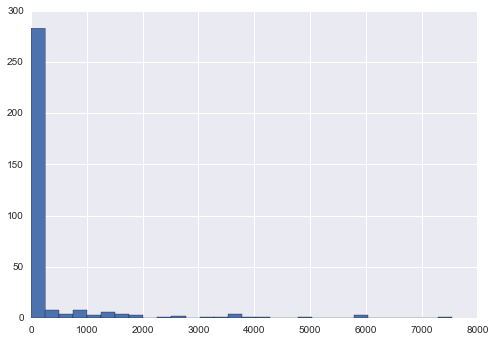

In [107]:
plt.hist(rnas, bins=30)

In [10]:
#Посмотрим, проассоциированны ли бины из значимых пар с топовыми РНК с генами и что это за гены, если там будут функциональные группы
#то похоже на регуляцию, что косвенно подтверждает
genesPositions = genesPositions()

In [11]:
genesStartPositions = {
    g.id:[i, g.location.start.position, g.location.end.position, g.strand] for i, j in genesPositions for g in j}

In [12]:
len(genesStartPositions)

57127

In [15]:
#::chr10:114134400-114135000
bins = [(int(b[2:].split(':')[1].split('-')[0]), int(b[2:].split(':')[1].split('-')[1]), b[2:].split(':')[0]) for b in allScores['Bin']]

In [16]:
bins[:5]

[(114134400, 114135000, 'chr10'),
 (114137550, 114138000, 'chr10'),
 (114142050, 114144000, 'chr10'),
 (114146850, 114147300, 'chr10'),
 (125803350, 125803800, 'chr10')]

In [21]:
#17:08 - 
from multiprocessing import Pool
pool = Pool(8)

binsGenes = []
binsGenes = pool.map(calculatePromotors, partitionList(bins))

pool.close()
pool.join()

+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+
+


KeyboardInterrupt: 

In [36]:
calculatePromotors([(33936900, 33937350, 'chr22')])

+


[[(33936900, 33937350, 'chr22'), None]]

In [25]:
binsGenes = [item for sublist in binsGenes for item in sublist]

In [37]:
binsGenes.append([(33936900, 33937350, 'chr22'), None])

In [43]:
l = [i[1] for i in binsGenes]

In [45]:
allScores['Gene with bin in promoter'] = l

In [31]:
allScores.to_csv("allScores_with_p_value_and_promoters.csv")

In [4]:
allScores = pd.read_csv("allScores_with_p_value_and_promoters.csv")

In [30]:
allScores.head()

,lncRNA,Transcript,Bin,Score,Corr,TranscriptLength,TranscriptGC,BinsLength,BinsGC,p-value,Gene with bin in promoter,has bin in promoter,significant p-value
0,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114134400-114135000,36.0,0.752150,795,47,600,47,9.708034e-03,ENSG00000197142.10,Yes,Yes
1,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114137550-114138000,88.0,0.752150,795,47,450,37,3.286936e-19,NaN,No,Yes
2,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114142050-114144000,74.0,0.890798,795,47,1950,47,4.160740e-10,NaN,No,Yes
3,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114146850-114147300,12.0,0.752150,795,47,450,39,3.039771e-01,NaN,No,No
4,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:125803350-125803800,24.0,0.743005,795,47,450,61,5.476132e-02,NaN,No,No


In [21]:
#Создать фичу "has bin in promoter", создать новую фичу "больше или меньше p-value 0.05" и построить countplot
#Создать фичу "top RNA" и построить countplot
allScores['has bin in promoter'] = ['No' if pd.isnull(g) else "Yes" for g in allScores['Gene with bin in promoter']]

In [22]:
allScores['significant p-value'] = ['No' if p >= 0.05 else "Yes" for p in allScores['p-value']]

In [33]:
rnas = allScores[allScores['p-value'] < 0.05].groupby(['lncRNA']).count()['p-value'].sort_values(ascending=False)

In [35]:
topRNAs = rnas[0:5]

In [39]:
allScores['top RNA'] = ['No' if l not in topRNAs else "Yes" for l in allScores['lncRNA']]

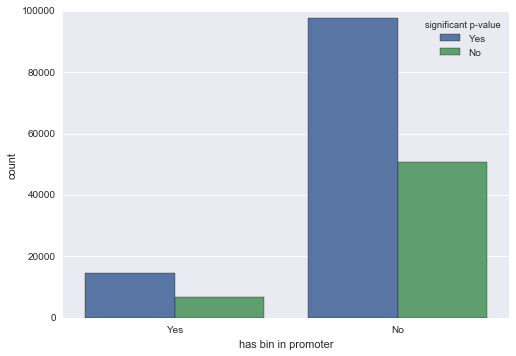

In [32]:
sb.countplot(x="has bin in promoter", hue="significant p-value", data=allScores)

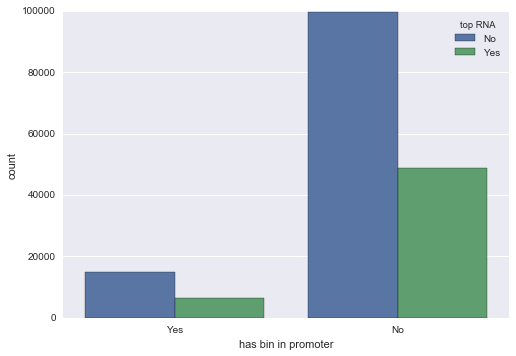

In [40]:
sb.countplot(x="has bin in promoter", hue="top RNA", data=allScores)

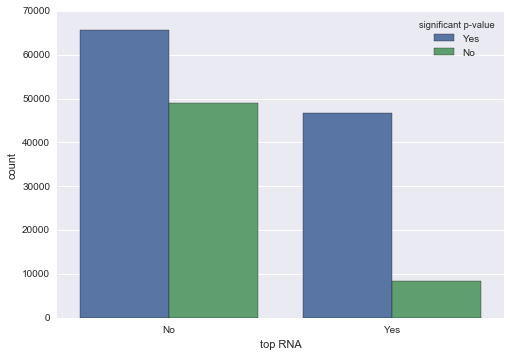

In [42]:
sb.countplot(x="top RNA", hue="significant p-value", data=allScores)

In [ ]:
#Посмотреть какие бины создают триплексы с максимальным количеством РНК(транскриптов)?

In [43]:
d = pd.read_csv("allScores_with_p_value_and_promoters.csv")

In [46]:
d.head()

,Unnamed: 0,lncRNA,Transcript,Bin,Score,Corr,TranscriptLength,TranscriptGC,BinsLength,BinsGC,p-value,Gene with bin in promoter,has bin in promoter,significant p-value
0,0,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114134400-114135000,36.0,0.752150,795,47,600,47,9.708034e-03,ENSG00000197142.10,Yes,Yes
1,1,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114137550-114138000,88.0,0.752150,795,47,450,37,3.286936e-19,NaN,No,Yes
2,2,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114142050-114144000,74.0,0.890798,795,47,1950,47,4.160740e-10,NaN,No,Yes
3,3,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:114146850-114147300,12.0,0.752150,795,47,450,39,3.039771e-01,NaN,No,No
4,4,ENSG00000259974.2,ENST00000420070.1::chr20:22528308-22541562,::chr10:125803350-125803800,24.0,0.743005,795,47,450,61,5.476132e-02,NaN,No,No


In [50]:
print set(d[(d['significant p-value'] == 'Yes') & (d['has bin in promoter'] == 'Yes')]['Gene with bin in promoter'])

set(['ENSG00000269416.5', 'ENSG00000239559.2', 'ENSG00000262558.1', 'ENSG00000221946.7', 'ENSG00000231105.1', 'ENSG00000270445.1', 'ENSG00000231509.1', 'ENSG00000101180.15', 'ENSG00000160808.9', 'ENSG00000252650.1', 'ENSG00000282012.1', 'ENSG00000240041.1', 'ENSG00000196240.3', 'ENSG00000267778.1', 'ENSG00000111859.16', 'ENSG00000235181.1', 'ENSG00000130433.7', 'ENSG00000123405.13', 'ENSG00000227017.1', 'ENSG00000189292.15', 'ENSG00000152556.15', 'ENSG00000236208.1', 'ENSG00000175040.5', 'ENSG00000167183.2', 'ENSG00000167641.10', 'ENSG00000271936.1', 'ENSG00000143627.17', 'ENSG00000135899.16', 'ENSG00000106327.12', 'ENSG00000225646.1', 'ENSG00000205309.13', 'ENSG00000236109.1', 'ENSG00000105613.9', 'ENSG00000132604.10', 'ENSG00000212387.1', 'ENSG00000265714.1', 'ENSG00000129991.12', 'ENSG00000159618.15', 'ENSG00000128604.18', 'ENSG00000279607.1', 'ENSG00000187912.11', 'ENSG00000124253.10', 'ENSG00000181896.11', 'ENSG00000230880.2', 'ENSG00000232963.1', 'ENSG00000236278.2', 'ENSG0000027

In [18]:
#binsCoords - список тюльпов вида (start, end, chr_name)
def calculatePromotors(binsCoords):
    binsGenes = []
    i = 0
    for b in binsCoords:
        startBinPosition = b[0]
        endBinPosition = b[1]
        chrom = b[2]

        hasGene = False
        genes = filterGenesByChrom(chrom)
        for gene, positions in genes.iteritems():
            if(positions[3] == 1):#+ цепь, значит TSS это start, значит делаем -1000/+1000 для получения зоны промотора
                promotorStart = positions[1] - 1000
                promotorEnd = positions[1] + 1000
            else:#- цепь, значит TSS это end, значит делаем +1000/-1000
                promotorStart = positions[2] - 1000
                promotorEnd = positions[2] + 1000

                #бин должен заходить в зону промотора как минимум на 150bp(почему?)
            if((endBinPosition - promotorStart >= binStep) & (promotorEnd - startBinPosition >= binStep)):
                binsGenes.append([b, gene])
                hasGene = True
                #бин может быть сразу в нескольких промоторах? Думаем что нет
                break;

        if(not hasGene):
            binsGenes.append([b, None])
        else:
            hasGene = False
            
        i = i + 1
    print "+"
    return binsGenes

In [8]:
def filterGenesByChrom(chrom):
    return {gene: positions for gene, positions in genesStartPositions.iteritems() if positions[0] == chrom}

In [9]:
def genesPositions():
    in_file = "gencode.v25lift37.annotation.gff3"
    in_handle = open(in_file)
    genes = []

    limit_info = dict(
        gff_id = ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 
     'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
        gff_type = ["gene"])

    genes = []
    for rec in GFF.parse(in_handle, limit_info=limit_info):
        genes.append((rec.id, rec.features)) 
    
    in_handle.close()
    
    return genes

In [7]:
def addParamsToScoresTable(allScores):
    seqs = []
    transcriptsLength = []
    transcriptsGC = []
    binsLength = []
    binsGC = []
    
    for seq_record in SeqIO.parse('./lnc_gff/all_transcripts_lncRNA.fa', "fasta"):
        seqs.append((seq_record.id, len(seq_record), int(GC(seq_record.seq))))
        
    transcripts = allScores['Transcript'].tolist()

    for t in transcripts:
        for s in seqs:
            if(t.split('::')[0] == s[0]):
                transcriptsLength.append(s[1])
                transcriptsGC.append(s[2])
                

    seqs = {}
    for l, b in zip(allScores['lncRNA'].tolist(), allScores['Bin'].tolist()):
        if l not in seqs:
            tmp = []
            for seq_record in SeqIO.parse('./bins_coords/seqs_for_lnc_' + l + ".fa", "fasta"):
                tmp.append((seq_record.id, len(seq_record), int(GC(seq_record.seq))))
            seqs[l] = tmp
        
        for s in seqs[l]:
            if(b == s[0]):
                binsLength.append(s[1])
                binsGC.append(s[2]) 
    
    allScores['TranscriptLength'] = transcriptsLength
    allScores['TranscriptGC'] = transcriptsGC
    allScores['BinsLength'] = binsLength
    allScores['BinsGC'] = binsGC

In [82]:
def calcPvalues(coords):
    p_value = []
    j = coords[0]
    for pl, score in zip(plogser[coords[0]:coords[1]], allScores['Score'].tolist()[coords[0]:coords[1]]):
        #индекс элемента + 11 = скор, надо брать сумму всех элементов в dist, больше или равный скору - p-value
        dist = getPmfWithCorrectParams(pnb, pl if pl < 1 else 0.965, score)
        p = sum([item for i, item in enumerate(dist) if i + 11 >= score])
        p_value.append((j, p))
        j = j + 1
    print str(j)
    return p_value

In [43]:
#как зависит максимальное количество триплексов в паре от параметров? надо чтобы суумма получалась = 1
def getPmfWithCorrectParams(pnb, pl, score):
    suma = 0
    n = 0
    count = 11
    while suma < 0.95 and n <= 100:
        n = n + 5
        suma = sum(getScoresPmf(3, 11, n, pnb, pl, 12))
    
    length = len(getScoresPmf(3, 11, n, pnb, pl, 12))
    while length + 11 <= score and score < 1000:
        count = count + 100
        length = len(getScoresPmf(3, 11, n, pnb, pl, count))
    return getScoresPmf(3, 11, n, pnb, pl, count)

In [9]:
def getCoordsByNumber(l):
    return [(e[0], WGBinsCoords.get(e[0])[e[1][0]][0], WGBinsCoords.get(e[0])[e[1][1]][1], e[3]) for e in l]

In [53]:
def correct_pvalues_for_multiple_testing(pvalues, real_n):                
    """                                                                                                   
    consistent with R - print correct_pvalues_for_multiple_testing([0.0, 0.01, 0.029, 0.03, 0.031, 0.05, 0.069, 0.07, 0.071, 0.09, 0.1]) 
    """
    from numpy import array, empty                                                                        
    pvalues = array(pvalues) 
    n = pvalues.shape[0]                                                                          
    new_pvalues = empty(n)                                                         
    values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]                                      
    values.sort()
    values.reverse()                                                                                  
    new_values = []
    for i, vals in enumerate(values):                                                                 
        rank = n - i
        pvalue, index = vals                                                                          
        new_values.append((real_n/rank) * pvalue)
        
    for i in xrange(0, int(n)-1):  
        if new_values[i] < new_values[i+1]:                                                           
            new_values[i+1] = new_values[i]
            
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
        
    return new_pvalues

In [11]:
def mergeBins(binss):
    tmpBins = []
    bins = []
    for b in binss:
        if len(tmpBins) > 0:
            if (b[1] - tmpBins[-1][1] == 1) and (b[0] == tmpBins[-1][0]):
                tmpBins.append(b)
            else:
                bins.append((tmpBins[-1][0], (tmpBins[0][1], tmpBins[-1][1]), len(tmpBins), max(tmpBins, key=lambda b: b[2])[2]))
                tmpBins[:] = []
                tmpBins.append(b)
        else:
            tmpBins.append(b)
    if(len(tmpBins) > 0):
        bins.append((tmpBins[-1][0], (tmpBins[0][1], tmpBins[-1][1]), len(tmpBins), max(tmpBins, key=lambda b: b[2])[2]))
    return bins

In [12]:
def parseTriplexatorResult(l):
    data = pd.read_csv(l + '.tsv', sep='\t')
    data = data[data['# Sequence-ID'].str.startswith('ENST')]
    if(len(data.index) == 0): return pd.DataFrame()
    dataGroup = data.groupby(['# Sequence-ID', 'Duplex-ID'])[["Score"]].sum()
    
    x = pd.DataFrame({'lncRNA':[l]*len(dataGroup.index.tolist()), 'Transcript': [i for i, j in dataGroup.index.tolist()],
                  'Bin' : [j for i, j in dataGroup.index.tolist()], 
                 'Score' : dataGroup['Score'].tolist(),
                 'Corr' : [t[3] for x in [j for i, j in dataGroup.index.tolist()] for t in coords.get(l) if str(t[0]) + ':' + str(t[1]) + '-' + str(t[2]) in x]})
    x = x.reindex_axis(['lncRNA','Transcript', 'Bin', 'Score', 'Corr'], axis=1)
    x.to_csv(l + ".csv")
    
    return x

In [13]:
#функции для симуляции последовательностей

In [49]:
def generateSequenceSet(count, a, t, g, c, length):
    sequenceset = []
    for i in range(0, count):
        sequenceset.append(''.join(np.random.choice(['A', 'T', 'G', 'C'], p=[a, t, g, c]) for i in range(length)))
    return sequenceset

In [48]:
def generateFasta(fileName, count, a, t, g, c, length):
    handle = open("./score_to_p-value/" + fileName, "a")
    i = 0
    for records in generateSequenceSet(count, a, t, g, c, length):
        SeqIO.write(SeqRecord(Seq(records, "rand_" + str(i)), id = "rand_" + str(i)), handle, "fasta")
        i = i + 1

In [47]:
def generateScoreDistribution(lncRNALength, binLength, lncRNAGC, binGC, count, triplexatorParam):
    lncRNAFileName = "generated_lncRNAs_" + str(lncRNALength) + "_" + str(binLength) + "_" + str(lncRNAGC) + "_" + str(binGC) + "_" + str(triplexatorParam) + ".fa"
    binFileName = "generated_bins_" + str(lncRNALength) + "_" + str(binLength) + "_" + str(lncRNAGC) + "_" + str(binGC) + "_" + str(triplexatorParam) + ".fa"
    outName = 'result_' + str(lncRNALength) + "_" + str(binLength) + "_" + str(lncRNAGC) + "_" + str(binGC) + "_" + str(triplexatorParam) + ".tpx"
    
    lncA=lncT=(100-lncRNAGC)/float(100)/2
    lncG=lncC=lncRNAGC/float(100)/2
    generateFasta(lncRNAFileName, count, lncA, lncT, lncG, lncC, lncRNALength)
    
    binA=binT=(100-binGC)/float(100)/2
    binG=binC=binGC/float(100)/2
    generateFasta(binFileName, count, binA, binT, binG, binC, binLength)
    
    os.chdir('./score_to_p-value')
    cmd = './triplexator -l 15 -E 3 -e 20 -c 2 -fr off -g 20 -fm 0 -of 1 -o ' + outName + ' -po -rm 2 -p 8 -ss ' + lncRNAFileName + ' -ds ' + binFileName
    print(cmd)
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    p.wait()
    print p.returncode
    
    data = pd.read_csv(outName, sep='\t')
    data = data[data['# Sequence-ID'].str.startswith('rand')]
    dataGroup = data.groupby(['# Sequence-ID', 'Duplex-ID'])[["Score"]].sum()
    
    scores = dataGroup['Score']
    counts = data.groupby(['# Sequence-ID', 'Duplex-ID'])[["Score"]].size().tolist()
    
    potential = pd.read_csv(outName + '.summary', sep='\t', index_col=False)
    
    print str(len(scores)) + " triplexes, Existing sums of triplexes = " + str(set(counts))
    
    return (data['Score'], scores, counts, potential['Total (rel)'])

In [ ]:
#Нужно изучить t-potential

In [50]:
os.chdir('/Users/e.mazurov/workspace/Epigenetics')
shutil.rmtree("./score_to_p-value")
os.mkdir("./score_to_p-value")
shutil.copyfile("triplexator", "./score_to_p-value/triplexator")
os.chmod("./score_to_p-value/triplexator", 0o777)
d = generateScoreDistribution(7000, 4000, 70, 60, 150, 15)

./triplexator -l 15 -E 3 -e 20 -c 2 -fr off -g 20 -fm 0 -of 1 -o result_7000_4000_70_60_15.tpx -po -rm 2 -p 8 -ss generated_lncRNAs_7000_4000_70_60_15.fa -ds generated_bins_7000_4000_70_60_15.fa
0
13371 triplexes, Existing sums of triplexes = set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 25, 28, 29, 34])


In [53]:
potential = [math.log(i) for i in d[3]]

(array([ 8218.,  2900.,  1776.,   425.,    43.,     9.]),
 array([-20.6010482 , -19.84417796, -19.08730772, -18.33043747,
        -17.57356723, -16.81669699, -16.05982674]),
 <a list of 6 Patch objects>)

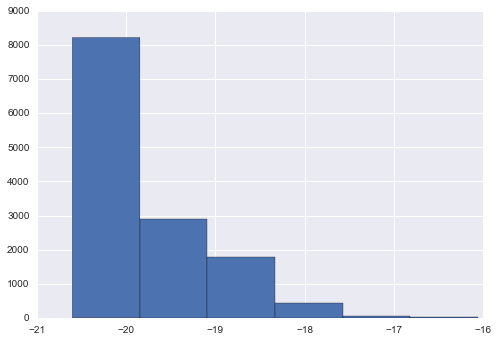

In [59]:
plt.hist(potential, bins=6)

In [ ]:
1)Понять, будут ли одинаковые параметры распределения potential для разных параметров модели
1а)Статьи с использованием триплекатора
2)У скольких РНК много бинов со значимой вероятностью образовать триплексы
3)Попробовать запустить с другой меткой(проверить известные случаи, например MEG3, у которой есть эксперимент про места в геноме, где связывается)
4)Прочитать статью MEG3, узнать какую метку ставит, где ставит
5)ChiRP-seq с MEG3 после триплексатора(получившиеся бины) сравнить с нашими бинами(умеем сравнивать две разметки на геноме)
6)Есть еще случаи lncRNA, про которые известно что они учавствуют в проставлении меток и с ними есть эксперименты
7)Сравнить бины просто с корреляцией экспрессии и меток с ChiRP-seq

In [46]:
def logserMLE(sumObservations, lenObservations, x0):
    return 1 - newton(logserMLEFunction, x0, args=(sumObservations, lenObservations))

In [47]:
def logserMLEFunction(x, sumObservations, lenObservations):
    return -sumObservations/(1 - x) - lenObservations/(x*math.log(x))

In [48]:
def nbMLE(sumObservations, lenObservations):
    return (lenObservations*3)/(lenObservations*3 + sumObservations)

In [49]:
def g(r, p, m):
    return (1 - p)**(-r) - sum(binom(x + r - 1, x)*p**x for x in range(0, m + 1))

In [50]:
def TNBpmf2(k, r, p, m):
    return [binom(i + r - 1, i)*(p**i)/g(r, p, m) if i > m else 0 for i in k]

In [51]:
def pmfOfSumTNB(s, n, r, p, m, pmf1, pmf2):
    s = s - 1#т.к. рекуррентная формула
    return (p/float(s + 1))*((s + n*r)*pmf1 + n*(r + m)*binom(r + m - 1, m)*(p**m)*pmf2*g(r, p, m)**(-1))

In [52]:
# r - параметр NB
# m - параметр TNB
# n - максимальное количество триплексов в одной паре
# PNB - вероятность в NB
# PLogser - вероятность в Logser
# count - количество элементов в каждой pmf(можем вычислить на основе s и n?) - как понять какой он должен быть?
def getScoresPmf(r, m, n, PNB, PLogser, count):
    #получаем список pmf для mixture
    pmfs = []
    pmfs.append(TNBpmf2(range(0, m + 1 + count), r, PNB, m))#первый pmf, сумма из одного TNB
    
    for i in range(2, n + 1):#кол-во элементов в сумме
        tmpTNB = [0 for z in range(0, (m + 1)*i)]
        tmpTNB.append(pmfs[0][m + 1]**2) if i == 2 else tmpTNB.append(pmfs[0][m + 1]*pmfs[i - 2][(m + 1)*(i - 1)])
        k = 0
        for j in range((m + 1)*i + 1, (m + 1)*i + count):
            tmpTNB.append(pmfOfSumTNB(j, i, r, PNB, m, tmpTNB[k + (m + 1)*i], pmfs[i - 2][k + (m + 1)*(i - 1) + 1]))
            k = k + 1
        pmfs.append(tmpTNB)
 
    distr = []
    ls = logser.pmf(range(1, n + 1), PLogser)
    
    for x in range(m + 1, n*(m + 1) + count + 1):
        tnbs = [pmfs[tnb][x]*ls[tnb] if x < len(pmfs[tnb]) else 0 for tnb in range(0, n)]
        distr.append(sum(tnbs))
    
    return distr